In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import copy
import itertools
import os
import re
import numpy as np
import pandas as pd
import scipy as sp
import operator
import scipy.stats as stats
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from spectral_connectivity import Multitaper, Connectivity

import datajoint as dj
import spyglass
from spyglass.common import (Session, IntervalList, LabMember, LabTeam, Raw, Session, Nwbfile, TaskEpoch,
                             Electrode, ElectrodeGroup, LFP, LFPSelection, LFPBand, LFPBandSelection)
from spyglass.common.common_position import (RawPosition, IntervalPositionInfo)

os.chdir("/home/jguidera/Src/MS_analysis_sam/")
from Task_event.ms_dio_event import DioEvents, ProcessedDioEvents
from Metadata.ms_task_identification import TaskIdentification
from Time_and_trials.ms_interval import EpochIntervalListName
from Metadata.metadata_helpers import get_ms_nwbf_epoch_keys
from Utils.df_helpers import df_pop, df_filter1_columns, df_from_data_list
from Datajoint_nwb_utils.nwbf_helpers import get_nwb_file
from Datajoint_nwb_utils.datajoint_table_helpers import format_nwb_file_name
from Utils.vector_helpers import unpack_single_element
from Utils.plot_helpers import format_ax
from Utils.stats_helpers import average_confidence_interval, circular_shuffle
from Utils.point_process_helpers import event_times_in_intervals_bool
from Task_event.ms_task_performance import *

os.chdir("/home/sambray/Documents/behavioral_analysis_AS/")
from AS_EM_module import EM_main

os.chdir("/home/sambray/Documents/MS_analysis_Jen/")

os.chdir('/home/sambray/Documents/MS_analysis_samsplaying/')
from ms_opto_stim_protocol import OptoStimProtocol
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>")) # set cells to be wide

[2024-03-28 11:43:09,214][INFO]: Connecting sambray@lmf-db.cin.ucsf.edu:3306
[2024-03-28 11:43:09,298][INFO]: Connected sambray@lmf-db.cin.ucsf.edu:3306
/tmp/ipykernel_4059885/91481280.py:42: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


## Populate behavior analysis tables

In [47]:
import warnings
warnings.filterwarnings('ignore')

# Populate tables for behavioral analysis of W track sessions
# TODO: get list of nwbf names used in MS analysis
nwb_file_names = ['Frodo20230815_.nwb']

for nwb_file_name in nwb_file_names:
    print(f"on {nwb_file_name}...")
    key = {"nwb_file_name": nwb_file_name}
    TaskIdentification.populate(key)
    epochs = []
    for contingency in ['lineartrack','Lineartrack','wtrack','Wtrack','w-track','W-Track']:
        epochs.extend((TaskIdentification & {**key, **{"contingency": contingency}}).fetch("epoch"))
    # epochs = np.append((TaskIdentification & {**key, **{"contingency": "wtrack"}}).fetch("epoch"),(TaskIdentification & {**key, **{"contingency": "lineartrack"}}).fetch("epoch"))
    for epoch in epochs:
        print(f"on epoch {epoch}...")
        key.update({"epoch": epoch})
        if not EpochIntervalListName & key:
            print('populating epochIntervalListName...')
            EpochIntervalListName.populate(key)
        if not DioEvents & key:
            print ('populating DioEvents...')
            DioEvents.populate(key)
        if not ProcessedDioEvents & key:
            print('populating ProcessedDioEvents...')
            ProcessedDioEvents.populate(key)
        if not AlternationTaskPerformance & key:
            print('populating AlternationTaskPerformance...')
            AlternationTaskPerformanceSel().insert1(key,skip_duplicates=True)
            AlternationTaskPerformance.populate(key)

In [ ]:
x = (ProcessedDioEvents & key).fetch("KEY")[0]
(TaskIdentification & x).fetch1("contingency") in ["wtrack","W-Track","W-track",'wtrack','w-track']
# ProcessedDioEvents & key
AlternationTaskPerformanceSel.insert1(x,skip_duplicates=True)

AlternationTaskPerformanceSel&x #& key

AlternationTaskPerformance.populate(x)
# key

In [ ]:
key = {'nwb_file_name': 'Frodo20230814_.nwb', 'epoch': 10}
# print((ProcessedDioEvents() & key).fetch1_dataframe().dio_event_names.values.size)
wells = (AlternationTaskPerformance & key).fetch('current_wells')[0]
reward = (AlternationTaskPerformance & key).fetch('reward_outcomes')[0]

for w,r in zip(wells,reward):
    print(w,r)  

## Get performance outcomes across epochs on w track, for each animal and for each trial type

In [36]:
# Get performance outcomes across epochs on w track, for each animal and for each trial type
#single day
nwb_file_names_map = {
                      "Yoshi": ["Yoshi20220517_.nwb",],#"Yoshi20220518_.nwb",],
                      "Olive": ["Olive20220711_.nwb"],
                      "Wallie": ["Wallie20220922_.nwb"],
                      "Bilbo":["Bilbo20230802_.nwb",],#"Bilbo20230804_.nwb"],# no entrainment
                      "Totoro": ["Totoro20220613_.nwb",],# "Totoro20220614_.nwb"],
                      "Winnie": ["Winnie20220719_.nwb",],# "Winnie20220720_.nwb"],
                      "Banner":["Banner20220224_.nwb",],#"Banner20220225_.nwb"],
                      "Frodo":["Frodo20230814_.nwb",],#"Frodo20230815_.nwb","Frodo20230816_.nwb",]
                      }  # entrainment  # 
#Multiple day
nwb_file_names_map = {
                      "Yoshi": ["Yoshi20220517_.nwb","Yoshi20220518_.nwb",],
                      "Olive": ["Olive20220711_.nwb"],
                      "Wallie": ["Wallie20220922_.nwb"],
                      "Bilbo":["Bilbo20230802_.nwb","Bilbo20230804_.nwb"],# no entrainment
                      "Totoro": ["Totoro20220613_.nwb", "Totoro20220614_.nwb"],
                      "Winnie": ["Winnie20220719_.nwb", "Winnie20220720_.nwb"],
                      "Banner":["Banner20220224_.nwb","Banner20220225_.nwb"],
                      "Frodo":["Frodo20230814_.nwb",],#"Frodo20230815_.nwb","Frodo20230816_.nwb",]
                      }  

# #Frodo with and without stim
# nwb_file_names_map = {
#     "Frodo_stim": ["Frodo20230814_.nwb","Frodo20230815_.nwb"],
#     "Frodo_no_stim": ["Frodo20230815_.nwb","Frodo20230816_.nwb"]
# }

# entrainment  # 
# nwb_file_names_map = {"Frodo":["Frodo20230814_.nwb","Frodo20230815_.nwb","Frodo20230816_.nwb",]}
# nwb_file_names_map = {"Winnie": ["Winnie20220719_.nwb", "Winnie20220720_.nwb"],}
# nwb_file_names_map = {"Bilbo":["Bilbo20230802_.nwb","Bilbo20230804_.nwb"]}
# nwb_file_names_map={"Wallie": ["Wallie20220922_.nwb"],"Totoro": ["Totoro20220613_.nwb","Totoro20220614_.nwb"]}#"Banner":["Banner20220224_.nwb"]}
# nwb_file_names_map = {"Banner24":["Banner20220224_.nwb",],
#                      "Banner25":["Banner20220225_.nwb"],
#                      "Banner":["Banner20220224_.nwb","Banner20220225_.nwb",]} 
trial_types = ["all", "outbound", "inbound"]
optogenetic_types = ['control','test', "all"]

data_list = []  # initialize list to store correct/incorrect outcomes 
# For nwb file names

for optogenetics in optogenetic_types:
    for rat_name, nwb_file_names in nwb_file_names_map.items():
        # Loop through trial types
        for trial_type in trial_types:
            resp_values = []
            # Loop through epochs where contingency is wtrack
            total_trial_count = 0
            trial_number = []
            for nwb_file_name in nwb_file_names:
                key = {"nwb_file_name": nwb_file_name}
                # Get epochs where contingency is wtrack
                epochs = []
                for contingency in ['wtrack','w-track']:
                    epochs.extend((TaskIdentification & {**key, **{"contingency": contingency}}).fetch("epoch"))
                if rat_name=='Frodo_stim' and nwb_file_name=='Frodo20230815_.nwb':
                    epochs = [2,4]
                if rat_name=='Frodo_no_stim' and nwb_file_name=='Frodo20230815_.nwb':
                    epochs = np.array(epochs)
                    epochs = epochs[epochs>5]
                print(key)
                print('Epochs:',epochs)
                
                for epoch in epochs:
                    key.update({"epoch": epoch})
    
                    # Get performance outcomes
                    table_intersection = (AlternationTaskPerformance & key)
                    if len(table_intersection) == 0:
                        print(f"no entry found in AlternationTaskPerformance for {key}")
                        continue
                    performance_outcomes = table_intersection.fetch1("performance_outcomes")
                    #SB: restrict by optogenetic period or control
                    if optogenetics in ['test','control']:
                        poke_event_times = (ProcessedDioEvents.FirstUpPokes() & key).fetch1("dio_first_poke_times")
                        # get the control interval
                        if EpochIntervalListName()&key:
                            pos_interval_name = (EpochIntervalListName()&key).fetch1('interval_list_name')
                            dio_info_key = {"nwb_file_name": nwb_file_name, "interval_list_name":pos_interval_name, 'dio_event_name':'stim'}
                            control_interval = OptoStimProtocol().get_control_intervals(dio_info_key)#[0][0]
                            if len(control_interval)==0:
                                print('missing parameterized optogenetics: ', dio_info_key)
                                continue
                            control_interval=control_interval[0][0]
                        else:
                            print(f'No position tracking for {key}. Assuming no stimulus interval')
                            control_interval = [0,1e20]
 
                        #label each event as in test or control
                        optogenetic_event = [(event_time<control_interval[0] or event_time>control_interval[1]) for event_time in poke_event_times]
                        # Restrict to inbound or outbound if indicated
                        if trial_type in ["inbound", "outbound"]:
                            optogenetic_event = [y for (x,y) in zip(performance_outcomes,optogenetic_event) if trial_type in x]
                            performance_outcomes = [x for x in performance_outcomes if trial_type in x]
                        epoch_trial_number = np.arange(len(performance_outcomes)) + total_trial_count
                        total_trial_count += len(epoch_trial_number)
                        #filter on condition
                        performance_outcomes = [x for (x,opto) in zip(performance_outcomes,optogenetic_event) if ((opto and optogenetics=='test') or ((not opto) and optogenetics=='control'))]             
                        epoch_trial_number = [x for (x,opto) in zip(epoch_trial_number,optogenetic_event) if ((opto and optogenetics=='test') or ((not opto) and optogenetics=='control'))]
                        
                    else: #no optogenetic restriction
                        # Restrict to inbound or outbound if indicated
                        if trial_type in ["inbound", "outbound"]:
                            performance_outcomes = [x for x in performance_outcomes if trial_type in x]
                        epoch_trial_number = np.arange(len(performance_outcomes)) + total_trial_count
                        total_trial_count += len(epoch_trial_number)
                    
                    # Convert to binary
                    performance_outcomes = np.asarray(performance_outcomes_to_int(performance_outcomes))
    
                    # Remove nans
                    resp_values.extend(performance_outcomes[np.isfinite(performance_outcomes)])
                    trial_number.extend(np.array(epoch_trial_number)[np.isfinite(performance_outcomes)])
                    
            # Store result
            data_list.append((rat_name, trial_type, resp_values, optogenetics, trial_number))
# Convert results to df
res_values_df = df_from_data_list(data_list, ["rat_name", "trial_type", "resp_values", "optogenetic_type", "trial_number"])

{'nwb_file_name': 'Yoshi20220517_.nwb'}
Epochs: [2, 4, 6, 8, 10, 12, 14, 16]
{'nwb_file_name': 'Yoshi20220518_.nwb'}
Epochs: [2, 4, 6, 8, 10, 12, 14, 16]
{'nwb_file_name': 'Yoshi20220517_.nwb'}
Epochs: [2, 4, 6, 8, 10, 12, 14, 16]
{'nwb_file_name': 'Yoshi20220518_.nwb'}
Epochs: [2, 4, 6, 8, 10, 12, 14, 16]
{'nwb_file_name': 'Yoshi20220517_.nwb'}
Epochs: [2, 4, 6, 8, 10, 12, 14, 16]
{'nwb_file_name': 'Yoshi20220518_.nwb'}
Epochs: [2, 4, 6, 8, 10, 12, 14, 16]
{'nwb_file_name': 'Olive20220711_.nwb'}
Epochs: [2, 4, 6, 8, 10, 12, 14, 16]
{'nwb_file_name': 'Olive20220711_.nwb'}
Epochs: [2, 4, 6, 8, 10, 12, 14, 16]
{'nwb_file_name': 'Olive20220711_.nwb'}
Epochs: [2, 4, 6, 8, 10, 12, 14, 16]
{'nwb_file_name': 'Wallie20220922_.nwb'}
Epochs: [2, 4, 6, 8, 10, 12, 14, 16, 18, 20]
{'nwb_file_name': 'Wallie20220922_.nwb'}
Epochs: [2, 4, 6, 8, 10, 12, 14, 16, 18, 20]
{'nwb_file_name': 'Wallie20220922_.nwb'}
Epochs: [2, 4, 6, 8, 10, 12, 14, 16, 18, 20]
{'nwb_file_name': 'Bilbo20230802_.nwb'}
Epochs: [

# Plot Learning curves

sigma2e: 0.25
Converged after 278 iterations
sigma2e is  0.019127260759661122
sigma2e: 0.25
Converged after 408 iterations
sigma2e is  0.011235810878329556
sigma2e: 0.25
Converged after 465 iterations
sigma2e is  0.010599751711422837
sigma2e: 0.25
Converged after 270 iterations
sigma2e is  0.017018839646159776
sigma2e: 0.25
Converged after 268 iterations
sigma2e is  0.00817694816270138
sigma2e: 0.25
Converged after 360 iterations
sigma2e is  0.006397938383705911
sigma2e: 0.25
Converged after 205 iterations
sigma2e is  0.1262273663157757
sigma2e: 0.25
Converged after 296 iterations
sigma2e is  0.13977807871021583
sigma2e: 0.25
Converged after 344 iterations
sigma2e is  0.08763365778640711
sigma2e: 0.25
Converged after 227 iterations
sigma2e is  0.09915476868595878
sigma2e: 0.25
Converged after 296 iterations
sigma2e is  0.013225785358501392
sigma2e: 0.25
Converged after 320 iterations
sigma2e is  0.010114707003687922
sigma2e: 0.25
Converged after 92 iterations
sigma2e is  0.244801777601

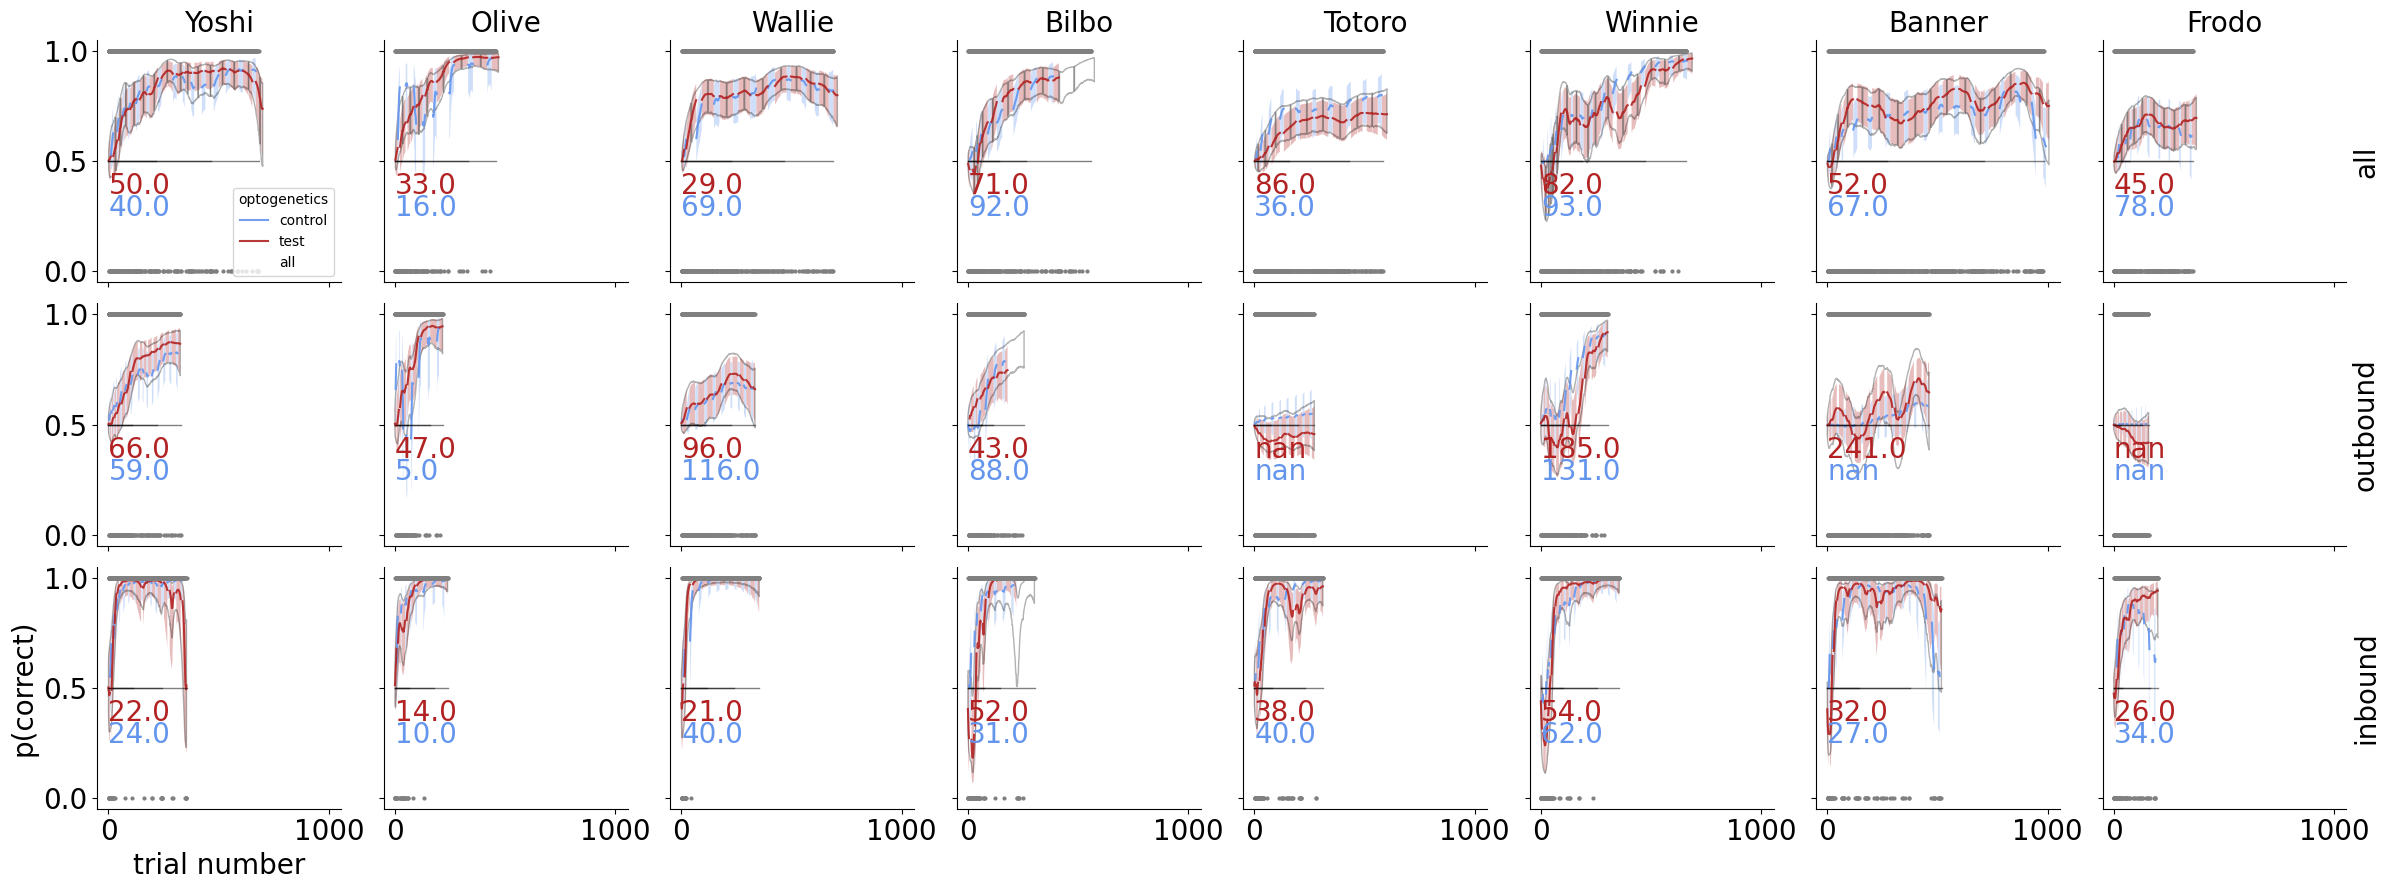

In [37]:
os.chdir("/home/sambray/Documents/behavioral_analysis_AS")
from AS_EM_module import EM_main, RunEM

# Plot parameters
p_init = .5
subplot_width = 3
subplot_height = 3

# Initialize figure
num_columns = max(len(nwb_file_names_map),2)
num_rows = len(trial_types)
fig, axes = plt.subplots(num_rows, num_columns, figsize=(subplot_width*num_columns, subplot_height*num_rows), sharex=True, sharey=True)

# Plot learning curves
data_list = []
for rat_name_idx, rat_name in enumerate(list(nwb_file_names_map.keys())):
    for trial_type_idx, trial_type in enumerate(trial_types):
        for optogenetics,color in zip (optogenetic_types,['cornflowerblue','firebrick','none']) :
            resp_values = df_pop(res_values_df, {"rat_name": rat_name, "trial_type": trial_type,'optogenetic_type':optogenetics,}, "resp_values")
            trial_number = df_pop(res_values_df, {"rat_name": rat_name, "trial_type": trial_type,'optogenetic_type':optogenetics,}, "trial_number")
            if len(resp_values) == 0:
                continue
            fig_ax_list = [fig, axes[trial_type_idx, rat_name_idx]]
            opto_label = "control"
            if optogenetics is "test":
                opto_label = "septal-transfected"
            fig, ax, pll, pul, pmode = EM_main(resp_values, p_init, fig_ax_list,color=color,label=optogenetics,trial_number=trial_number)
            # Store lower limit 
            data_list.append((rat_name, trial_type, pll,optogenetics,trial_number,pmode))
            title = ""
            ylabel = ""
            xlabel = ""
            if trial_type_idx == 0:
                title = rat_name
            if trial_type_idx == len(trial_types) - 1 and rat_name_idx == 0:
                ylabel = "p(correct)"
                xlabel = "trial number"
            if rat_name_idx == len(nwb_file_names_map)-1:
                ylabel=trial_type
                ax.yaxis.set_label_position("right")
        format_ax(ax=ax, title=title, xlabel=xlabel, ylabel=ylabel)
        fig.tight_layout()
        
# Add text to indicate learning trial
def get_first_entry_else_nan(x):
    if len(x) == 0:
        return np.nan
    return x[0]
pll_df = df_from_data_list(data_list, ["rat_name", "trial_type", "pll","optogenetic_type","trial_number","pmode"])
learning_trials = [get_first_entry_else_nan(np.where(pll > .5)[0]) for pll in pll_df.pll]
def indxVal_else_nan(values,indx):
    if indx is np.nan:
        return np.nan
    return values[indx]
learning_trials = [indxVal_else_nan(trial_number,ind) for(trial_number, ind) in zip(pll_df.trial_number,learning_trials)]
pll_df["learning_trial"] = learning_trials

for rat_name_idx, rat_name in enumerate(nwb_file_names_map.keys()):
    for trial_type_idx, trial_type in enumerate(trial_types):
        for loc,(optogenetics,color) in enumerate(zip(optogenetic_types,['cornflowerblue','firebrick'])):
            resp_values = df_pop(res_values_df, {"rat_name": rat_name, "trial_type": trial_type,'optogenetic_type':optogenetics}, "resp_values")
            if len(resp_values) == 0:
                continue
            learning_trial = df_pop(pll_df, {"rat_name": rat_name, "trial_type": trial_type,'optogenetic_type':optogenetics}, "learning_trial")
            ax = axes[trial_type_idx, rat_name_idx]
            ax.text(0, .25+.1*loc, learning_trial, fontsize=20,color=color)
axes[0,0].legend(loc='lower right',title='optogenetics')

In [ ]:
plt.rcParams['svg.fonttype']='none'
os.chdir('/home/sambray/Documents/MS_analysis_samsplaying/Plots/')
fig.savefig('20230724_wTrack_curves_separated_globalTrialCount_gap.png')
fig.savefig('20230724_wTrack_curves_separated_globalTrialCount_gap.svg')

## Learning Trial comparison (within animal)

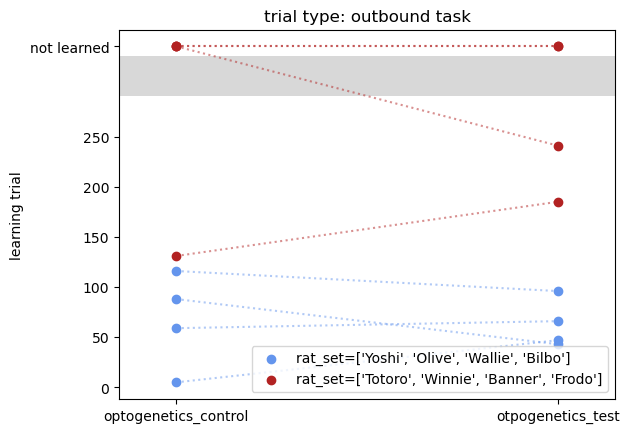

In [9]:
trial_type = 'outbound'
control_rats = ["Yoshi", "Olive", "Wallie","Bilbo"]
opto_rats = ["Totoro", "Winnie", "Banner","Frodo"]
set_nan = 340
df_ = pll_df[(pll_df['trial_type']==trial_type)].copy()

included_nan = False
for rat_set, color in zip([control_rats, opto_rats],['cornflowerblue','firebrick']):
    label = f'{rat_set=}'
    for rat_name in rat_set:
        lt_test = df_[(df_['optogenetic_type']=='test') & (df_['rat_name']==rat_name)]['learning_trial']
        lt_control = df_[(df_['optogenetic_type']=='control') & (df_['rat_name']==rat_name)]['learning_trial']
        if any(np.isnan([lt_test,lt_control])):# or np.isnan(lt_control):
            included_nan = True
        lt_test = np.nan_to_num(lt_test,nan=set_nan)
        lt_control = np.nan_to_num(lt_control,nan=set_nan)
        plt.scatter([0,1],[lt_control,lt_test,], color=color,label=label)
        plt.plot([0,1],[lt_control,lt_test,], color=color,ls=':', alpha=.5)
        label = None

plt.legend()
plt.xticks([0,1],labels=['optogenetics_control','otpogenetics_test'])
plt.ylabel('learning trial')
plt.title(f'trial type: {trial_type} task')
plt.xlim(-.15,1.15)
if included_nan:
    plt.fill_between([-1,2],[set_nan-10,set_nan-10],[set_nan-50,set_nan-50],facecolor='grey',alpha = .3)
    yticks = np.append(np.arange(0,251,50),[set_nan])
    yticks_labels = list(yticks.copy())
    yticks_labels[-1] = 'not learned'
    
    plt.yticks(yticks,labels=yticks_labels)

## Learning Trial comparison between animals

Yoshi 22.0 64.0 43.0
Olive 8.0 26.0 14.0
Wallie 20.0 40.0 22.0
Bilbo 41.0 66.0 61.0
Totoro 36.0 340.0 63.0
Winnie 54.0 170.0 80.0
Banner 28.0 222.0 47.0
Frodo 23.0 355.0 39.0


Text(0.5, 1.0, 'all')

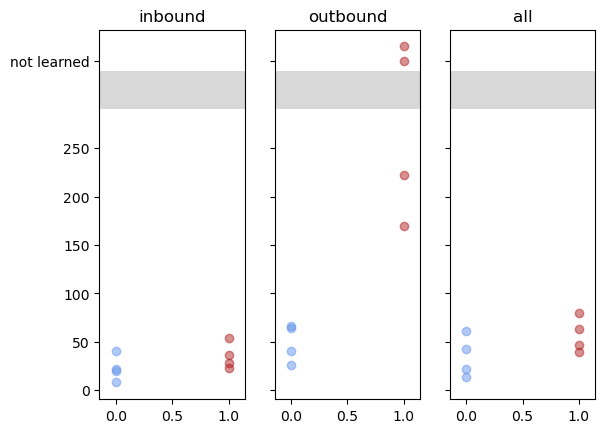

In [46]:
trial_type = 'outbound'
control_rats = ["Yoshi", "Olive", "Wallie","Bilbo"]
opto_rats = ["Totoro", "Winnie", "Banner","Frodo"]
set_nan = 340
df_ = pll_df#[(pll_df['trial_type']==trial_type)].copy()

trial_type = "all" #optogenetic trial type
fig, ax = plt.subplots(ncols=3,sharey=True)
included_nan = False
for i,(rat_set, color) in enumerate(zip([control_rats, opto_rats],['cornflowerblue','firebrick'])):
    label = f'{rat_set=}'
    for ii,(rat_name) in enumerate(rat_set):
        lt_in = df_[(df_['optogenetic_type']==trial_type) 
                    & (df_['rat_name']==rat_name)
                    & (df_.trial_type=="inbound")]['learning_trial'].values[0]
        lt_out = df_[(df_['optogenetic_type']==trial_type) 
                    & (df_['rat_name']==rat_name)
                    & (df_.trial_type=="outbound")]['learning_trial'].values[0]
        lt_all = df_[(df_['optogenetic_type']==trial_type) 
                    & (df_['rat_name']==rat_name)
                    & (df_.trial_type==trial_type)]['learning_trial'].values[0]
        if any(np.isnan([lt_in, lt_out])):# or np.isnan(lt_control):
            included_nan = True
        lt_out = np.nan_to_num(lt_out,nan=set_nan+ii*5)
        lt_in = np.nan_to_num(lt_in,nan=set_nan+ii*5)
        ax[0].scatter([i],[lt_in], color=color,label=label,alpha=.5)
        ax[1].scatter([i],[lt_out], color=color,label=label,alpha=.5)
        ax[2].scatter([i],[lt_all], color=color,label=label,alpha=.5)
        label = None
        print(rat_name,lt_in,lt_out,lt_all)
if included_nan:
    for a in ax:
        a.fill_between([-1,2],[set_nan-10,set_nan-10],[set_nan-50,set_nan-50],facecolor='grey',alpha = .3)
        yticks = np.append(np.arange(0,251,50),[set_nan])
        yticks_labels = list(yticks.copy())
        yticks_labels[-1] = 'not learned'
        a.set_yticks(yticks,labels=yticks_labels)
        a.set_xlim(-.15,1.15)
ax[0].set_title('inbound')
ax[1].set_title('outbound')
ax[2].set_title('all')

# Correct Fraction First n trials

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 1.0, 'trial type: outbound task, p = 0.001')

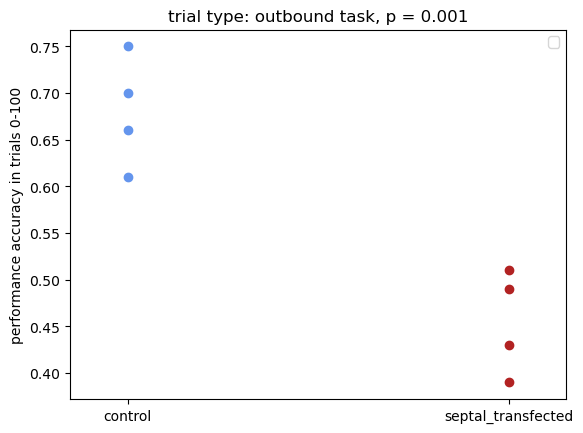

In [7]:
trial_type = 'outbound'
control_rats = ["Yoshi", "Olive", "Wallie","Bilbo"]
opto_rats = ["Totoro", "Winnie", "Banner","Frodo"]
trial_sample =(0,100)
df_ = res_values_df[(res_values_df['trial_type']==trial_type)].copy()
fig=plt.figure()
results = []
for i,(rat_set, color) in enumerate(zip([control_rats, opto_rats],['cornflowerblue','firebrick'])):
    results.append([])
    for rat_name in rat_set:
        lt_test = np.mean(np.asarray(df_[(df_['optogenetic_type']=='test') & (df_['rat_name']==rat_name)]['resp_values'])[0][trial_sample[0]:trial_sample[1]])
        results[-1].append(lt_test)
    plt.scatter(np.ones_like(results[-1])*i,results[-1],color=color)

    
plt.legend()
plt.xticks([0,1],labels=['control','septal_transfected'])
plt.ylabel('learning trial')
plt.ylabel(f"performance accuracy in trials {trial_sample[0]}-{trial_sample[1]}" )
plt.xlim(-.15,1.15)

from scipy.stats import ttest_ind
plt.title(f'trial type: {trial_type} task, p = {np.round(ttest_ind(*results)[1],3)}')

In [ ]:
plt.rcParams['svg.fonttype']='none'
os.chdir('/home/sambray/Documents/MS_analysis_samsplaying/Plots/')
filename = '20230724_performance_accuracy'
fig.savefig(filename+'.png')
fig.savefig(filename+'.svg')

In [ ]:
df_[df_['optogenetic_type']=='test']
res_values_df[(pll_df['trial_type']==trial_type)].copy()

### Learning curve slope

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


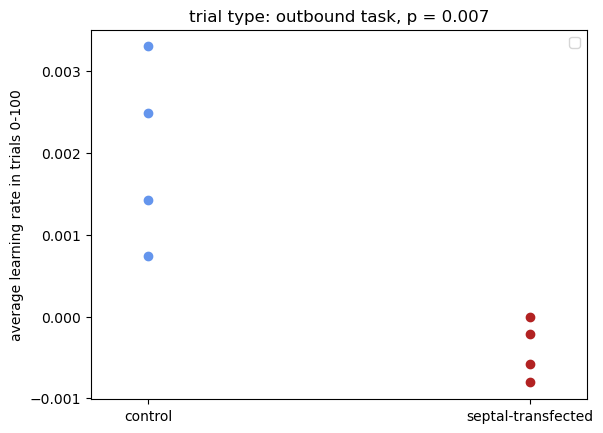

In [8]:
from scipy.stats import linregress

trial_type = 'outbound'
control_rats = ["Yoshi", "Olive", "Wallie","Bilbo"]
opto_rats = ["Totoro", "Winnie", "Banner","Frodo"]
trial_sample =(0,100)

df_ = pll_df[(pll_df['trial_type']==trial_type)].copy()

fig=plt.figure()
results = []
for i,(rat_set, color) in enumerate(zip([control_rats, opto_rats],['cornflowerblue','firebrick'])):
    results.append([])
    for rat_name in rat_set:
        pmode = np.asarray(df_[(df_['optogenetic_type']=='test') & (df_['rat_name']==rat_name)]['pmode'])[0][trial_sample[0]:trial_sample[1]]
        trial_number =np.asarray(df_[(df_['optogenetic_type']=='test') & (df_['rat_name']==rat_name)]['trial_number'])[0][trial_sample[0]:trial_sample[1]]
        slope = linregress(trial_number,pmode)[0]
        results[-1].append(slope)
    plt.scatter(np.ones_like(results[-1])*i,results[-1],color=color)

plt.legend()
plt.xticks([0,1],labels=['control','septal-transfected'])
plt.ylabel(f"average learning rate in trials {trial_sample[0]}-{trial_sample[1]}" )
plt.xlim(-.15,1.15)

from scipy.stats import ttest_ind
plt.title(f'trial type: {trial_type} task, p = {np.round(ttest_ind(*results)[1],3)}')
plt.rcParams['svg.fonttype']='none'
figname = "/home/sambray/Documents/MS_analysis_samsplaying/Plots/Abhilashsa_20220724/behavior/learning_rate"
fig.savefig(figname+".png")
fig.savefig(figname+".svg")